The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.
## Training an image classifier
Training an image classifier
We will do the following steps in order:

Load and normalize the CIFAR10 training and test datasets using torchvision

Define a Convolutional Neural Network

Define a loss function

Train the network on the training data

Test the network on the test data
### 1. Load and normalize CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
# The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)

batch_size = 4
trainset = torchvision.datasets.CIFAR10(root='./data',train=True,
                                        download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

170499072it [00:20, 8500558.52it/s]                                


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


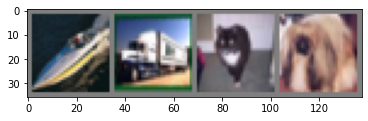

ship  truck cat   dog  


In [3]:
# show some of the training images
import matplotlib.pyplot as plt
import numpy as np
# functions to show an image
def imshow(img):
    img = img/2 + 0.5 #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images,labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2. Define a Convolutional Neural Network
Copy the neural network from the Neural Networks section before and modify it to take 3-channel images (instead of 1-channel images as it was defined).

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 3. Define a Loss function and optimizer
Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network
This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [6]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.195
[1,  4000] loss: 1.845
[1,  6000] loss: 1.671
[1,  8000] loss: 1.587
[1, 10000] loss: 1.504
[1, 12000] loss: 1.506
[2,  2000] loss: 1.398
[2,  4000] loss: 1.384
[2,  6000] loss: 1.362
[2,  8000] loss: 1.314
[2, 10000] loss: 1.305
[2, 12000] loss: 1.285
Finished Training


In [7]:
# Let’s quickly save our trained model:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### 5. Test the network on the test data
display an image from the test set to get familiar

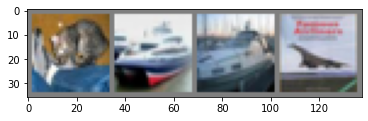

GroundTruth:  cat   ship  ship  plane


In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [9]:
# load back in our saved model (note: saving and re-loading the model wasn’t necessary here, we only did it to illustrate how to do so):
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [10]:
# see what the neural network thinks these examples above are:
outputs = net(images)
# The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  plane plane


In [11]:
# Let us look at how the network performs on the whole dataset.
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 55 %


In [12]:
# what are the classes that performed well, and the classes that did not perform well
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 59.2 %
Accuracy for class: car   is 77.5 %
Accuracy for class: bird  is 33.0 %
Accuracy for class: cat   is 47.2 %
Accuracy for class: deer  is 37.1 %
Accuracy for class: dog   is 40.9 %
Accuracy for class: frog  is 61.7 %
Accuracy for class: horse is 60.2 %
Accuracy for class: ship  is 79.4 %
Accuracy for class: truck is 59.0 %


## Training on GPU
 first define our device as the first visible cuda device if we have CUDA available

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [14]:
# The rest of this section assumes that device is a CUDA device.
# Then these methods will recursively go over all modules and convert their parameters and buffers to CUDA tensors
net.to(device)
# Remember that you will have to send the inputs and targets at every step to the GPU too:
inputs, labels = data[0].to(device), data[1].to(device)

In [15]:
del dataiter